## A note book to review and summarize QC metrics for HRApop v1.0

## Install and import libraries

In [1]:
%pip install requests wget pandas seaborn duckdb

import os
import requests
import wget  # pip install wget
import pandas as pd
import seaborn as sns
import duckdb
import matplotlib.pyplot as plt
import gzip

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Load data

In [2]:
# Define folder and file info
folder_path = "data"
file_name = "sc-transcriptomics-cell-instances.csv.gz"
file_name_expanded = "sc-transcriptomics-cell-instances.csv"
file_url = "https://zenodo.org/records/15786154/files/sc-transcriptomics-cell-instances.csv.gz?download=1"
file_path = os.path.join(folder_path, file_name)

# Create folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Download only if file is missing
if not os.path.exists(file_path):
    print(f"Downloading {file_name}...")
    wget.download(file_url, out=file_path, bar=None)  # no progress bar
    print("\nDownload complete.")
else:
    print("File already exists, skipping download.")

File already exists, skipping download.


In [3]:
with gzip.open(file_path, "rb") as f_in, open(
    f"{folder_path}/{file_name_expanded}", "wb"
) as f_out:
    while chunk := f_in.read(1024 * 1024):  # 1 MB chunks
        f_out.write(chunk)

## Preprocess data with `duckdb`

In [4]:
dtype_dict = {
    "organ": "str",
    "tool": "category",
    "cell": "str",
    "confidence_score": "float32",
}

df = pd.read_csv(
    file_path,
    compression="gzip",
    dtype=dtype_dict,
    # usecols=dtype_dict.keys()
)
df

,dataset,organ,tool,cell,cell_id,cell_label,match_type,confidence_score
0,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0000178,popv,covid_555_1.1,CL:0000232,erythrocyte,skos:exactMatch,1.000000
1,https://entity.api.hubmapconsortium.org/entiti...,UBERON:0000059,popv,AAACAGCCATCTAGCA,CL:0000625,"CD8-positive, alpha-beta T cell",skos:exactMatch,0.333333
2,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0002048,popv,AAACCTGGTTGTGGCC-1-HCATisStab7509734,CL:0002144,capillary endothelial cell,skos:exactMatch,1.000000
3,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0000178,popv,NaN,CL:0000814,mature NK T cell,skos:exactMatch,1.000000
4,https://entity.api.hubmapconsortium.org/entiti...,UBERON:0000059,popv,AAACATGCAATAATCC,CL:1000320,large intestine goblet cell,skos:exactMatch,0.500000
...,...,...,...,...,...,...,...,...
69582058,https://entity.api.hubmapconsortium.org/entiti...,UBERON:0002048,azimuth,TTCACGCATTCACGCACAACCACA,CL:0002063,AT2,skos:exactMatch,0.388534
69582059,https://entity.api.hubmapconsortium.org/entiti...,UBERON:0002048,azimuth,TTCACGCATTCACGCACAAGGAGC,CL:0002063,AT2,skos:exactMatch,0.624827
69582060,https://entity.api.hubmapconsortium.org/entiti...,UBERON:0002048,azimuth,TTCACGCATTCACGCACAGCGTTA,CL:4028002,EC general capillary,skos:exactMatch,0.290839
69582061,https://entity.api.hubmapconsortium.org/entiti...,UBERON:0002048,azimuth,TTCACGCATTCACGCACATACCAA,CL:0002063,AT2,skos:exactMatch,0.553495


In [5]:
# Combine cell instances and normalize columns for analysis
data_dir = folder_path
query = f"""
SELECT
  dataset as dataset,
  organ as organ,
  tool tool,
  cell as cell,
  cell_id as cell_id,
  cell_label as cell_label,
  match_type,
  confidence_score as confidence_score,
FROM read_csv('data/{ file_name_expanded }', union_by_name = true, filename = true, ignore_errors=true, quote='"')
"""

cells = duckdb.sql(query)
cells.write_csv(f"{ data_dir }/cell-instances.csv.gz")
cells.show()

┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬────────────────┬────────────┬──────────────────────────────────────────┬──────────────────┬────────────────────────────────────────┬──────────────────┬────────────────────┐
│                                                               dataset                                                                │     organ      │    tool    │                   cell                   │     cell_id      │               cell_label               │    match_type    │  confidence_score  │
│                                                               varchar                                                                │    varchar     │  varchar   │                 varchar                  │     varchar      │                varchar                 │     varchar      │       double       │
├─────────────────────────────────────────────────────────────────────

In [6]:
df_confidence = cells.to_df()
df_confidence.head()

,dataset,organ,tool,cell,cell_id,cell_label,match_type,confidence_score
0,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0000178,popv,covid_555_1.1,CL:0000232,erythrocyte,skos:exactMatch,1.000000
1,https://entity.api.hubmapconsortium.org/entiti...,UBERON:0000059,popv,AAACAGCCATCTAGCA,CL:0000625,"CD8-positive, alpha-beta T cell",skos:exactMatch,0.333333
2,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0002048,popv,AAACCTGGTTGTGGCC-1-HCATisStab7509734,CL:0002144,capillary endothelial cell,skos:exactMatch,1.000000
3,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0000178,popv,None,CL:0000814,mature NK T cell,skos:exactMatch,1.000000
4,https://entity.api.hubmapconsortium.org/entiti...,UBERON:0000059,popv,AAACATGCAATAATCC,CL:1000320,large intestine goblet cell,skos:exactMatch,0.500000


In [7]:
df_confidence = df_confidence.rename(columns={
  "dataset":"dataset_id"
})

## Filter

In [8]:
# Load Sankey CSV to add organ name
try:
    df_sankey = pd.read_csv(
        "https://raw.githubusercontent.com/x-atlas-consortia/hra-pop/refs/heads/main/output-data/v1.0/reports/universe-ad-hoc/sankey.csv"
    )[["organ_name", "dataset_id","is_atlas_dataset"]]

except:
    df_sankey = pd.read_csv("data/sankey.csv")[
        ["organ_name", "dataset_id", "is_atlas_dataset"]
    ]

# Workaround if GitHub gives 429 error:
# https://cdn.jsdelivr.net/gh/<user>/<repo>@<branch>/<filepath>

df_sankey.head()

C:\Users\abueckle\AppData\Local\Temp\1\ipykernel_267956\4160230505.py:3: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sankey = pd.read_csv(


,organ_name,dataset_id,is_atlas_dataset
0,small intestine,hhttps://api.cellxgene.cziscience.com/dp/v1/co...,False
1,right kidney,http://dx.doi.org/10.1681/ASN.2016091027#Donor...,False
2,right kidney,http://dx.doi.org/10.1681/ASN.2016091027#Donor...,False
3,right kidney,http://dx.doi.org/10.1681/ASN.2016091027#Donor...,False
4,mesenteric lymph node,http://purl.org/ccf/1.5/omap-1#Donor1_TissueBl...,False


In [9]:
df_merged = df_confidence.merge(df_sankey, on="dataset_id", how="outer").drop_duplicates()
df_merged.head()

,dataset_id,organ,tool,cell,cell_id,cell_label,match_type,confidence_score,organ_name,is_atlas_dataset
0,hhttps://api.cellxgene.cziscience.com/dp/v1/co...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,small intestine,False
1,http://dx.doi.org/10.1681/ASN.2016091027#Donor...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right kidney,False
2,http://dx.doi.org/10.1681/ASN.2016091027#Donor...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right kidney,False
3,http://dx.doi.org/10.1681/ASN.2016091027#Donor...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right kidney,False
4,http://purl.org/ccf/1.5/omap-1#Donor1_TissueBl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mesenteric lymph node,False


In [10]:
df_visualize = df_merged[df_merged['is_atlas_dataset'] == True]
df_visualize.head()

,dataset_id,organ,tool,cell,cell_id,cell_label,match_type,confidence_score,organ_name,is_atlas_dataset
29232641,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0002048,azimuth,D122_AAACCCAAGCAGCAGT,ASCTB-TEMP:non-classical-monocytes,Non-classical monocytes,skos:exactMatch,0.917274,respiratory system,True
29232644,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0002048,azimuth,D122_AAACGAAAGCTTCGTA,ASCTB-TEMP:monocyte-derived-m,Monocyte-derived Mφ,skos:exactMatch,0.941046,respiratory system,True
29232647,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0002048,azimuth,D122_AAACGAAAGGAACGCT,ASCTB-TEMP:monocyte-derived-m,Monocyte-derived Mφ,skos:exactMatch,0.882121,respiratory system,True
29232650,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0002048,azimuth,D122_AAACGAAAGTGTCATC,ASCTB-TEMP:monocyte-derived-m,Monocyte-derived Mφ,skos:exactMatch,0.951219,respiratory system,True
29232653,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0002048,azimuth,D122_AAACGCTCAACACGTT,ASCTB-TEMP:non-classical-monocytes,Non-classical monocytes,skos:exactMatch,0.937078,respiratory system,True


In [11]:
df_visualize

,dataset_id,organ,tool,cell,cell_id,cell_label,match_type,confidence_score,organ_name,is_atlas_dataset
29232641,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0002048,azimuth,D122_AAACCCAAGCAGCAGT,ASCTB-TEMP:non-classical-monocytes,Non-classical monocytes,skos:exactMatch,0.917274,respiratory system,True
29232644,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0002048,azimuth,D122_AAACGAAAGCTTCGTA,ASCTB-TEMP:monocyte-derived-m,Monocyte-derived Mφ,skos:exactMatch,0.941046,respiratory system,True
29232647,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0002048,azimuth,D122_AAACGAAAGGAACGCT,ASCTB-TEMP:monocyte-derived-m,Monocyte-derived Mφ,skos:exactMatch,0.882121,respiratory system,True
29232650,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0002048,azimuth,D122_AAACGAAAGTGTCATC,ASCTB-TEMP:monocyte-derived-m,Monocyte-derived Mφ,skos:exactMatch,0.951219,respiratory system,True
29232653,https://api.cellxgene.cziscience.com/dp/v1/col...,UBERON:0002048,azimuth,D122_AAACGCTCAACACGTT,ASCTB-TEMP:non-classical-monocytes,Non-classical monocytes,skos:exactMatch,0.937078,respiratory system,True
...,...,...,...,...,...,...,...,...,...,...
137242119,https://entity.api.sennetconsortium.org/entiti...,UBERON:0002048,azimuth,TTTGTTGGTATCATGC,CL:0002062,AT1,skos:exactMatch,0.561524,respiratory system,True
137242122,https://entity.api.sennetconsortium.org/entiti...,UBERON:0002048,azimuth,TTTGTTGGTCTCTCAC,CL:0002062,AT1,skos:exactMatch,0.690080,respiratory system,True
137242125,https://entity.api.sennetconsortium.org/entiti...,UBERON:0002048,azimuth,TTTGTTGGTGACACGA,CL:0002062,AT1,skos:exactMatch,0.738988,respiratory system,True
137242128,https://entity.api.sennetconsortium.org/entiti...,UBERON:0002048,azimuth,TTTGTTGTCCAAGAGG,CL:0017000,Ionocyte,skos:exactMatch,0.701889,respiratory system,True


## Get counts

In [12]:
mean_scores = df_visualize.groupby("tool")["confidence_score"].mean()
mean_scores

tool
azimuth       0.620791
celltypist    0.465863
popv          0.706241
Name: confidence_score, dtype: float64

In [13]:
scores_stats = (
    df_visualize.groupby("tool")[["confidence_score"]]
    .agg(["mean", "median", "std"])
    .reset_index()
)
scores_stats

tool confidence_score                    
                          mean    median       std
0     azimuth         0.620791  0.675149  0.260050
1  celltypist         0.465863  0.344071  0.365103
2        popv         0.706241  0.666667  0.240470

## Visualize

In [14]:
sns.set_theme(rc={"figure.figsize": (16, 8)})

plt.rcParams.update(
    {
        "font.size": 17,  # Controls default text size
        "axes.labelsize": 20,  # Controls axes label size
        "xtick.labelsize": 17,  # Controls x-axis tick label size
        "ytick.labelsize": 17,  # Controls y-axis tick label size
        "legend.fontsize": 18,
        "legend.title_fontsize":18
    }
)  # Controls legend font size

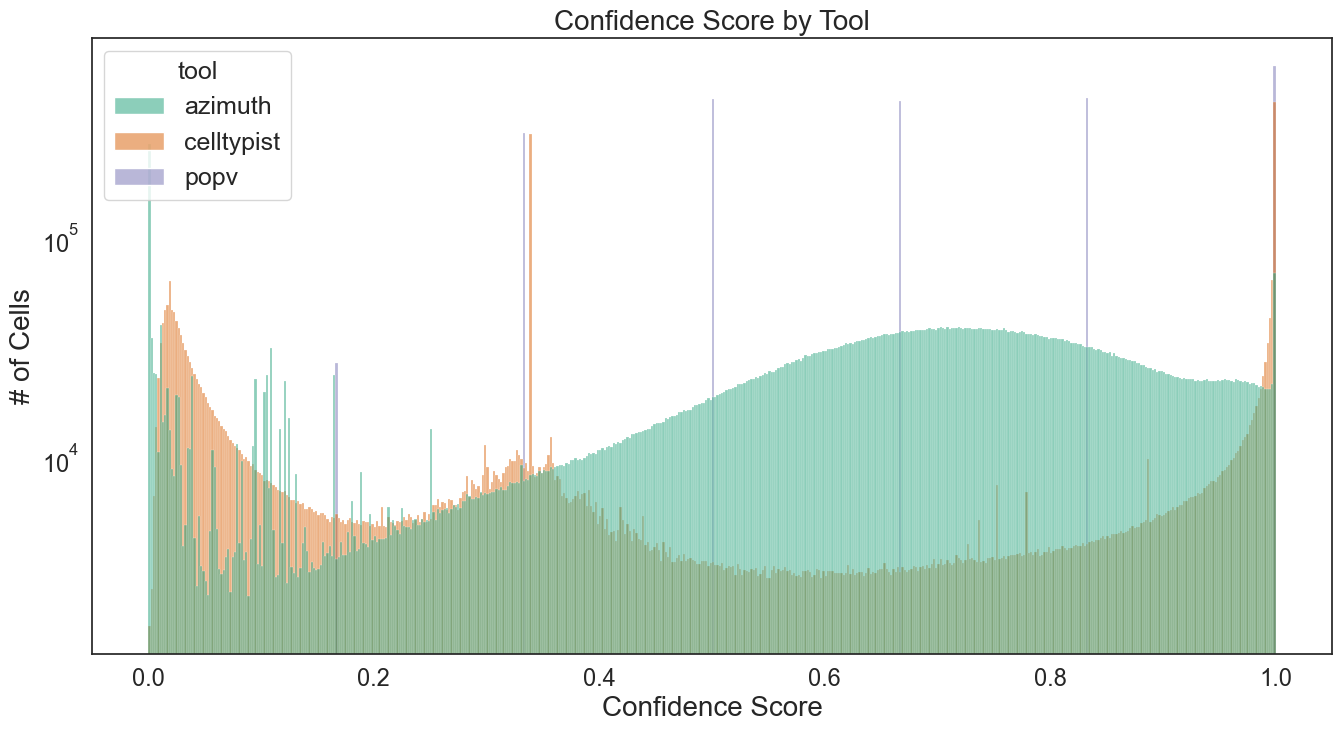

In [19]:
# make plot
g = sns.histplot(
    data=df_visualize,
    x="confidence_score",
    binwidth=0.002,
    hue="tool",
    palette="Dark2",
)

# Set the style to white
sns.set_style("white")

# adjust scales
plt.yscale("log")

# adjust labels++
plt.title("Confidence Score by Tool", fontsize=20)
plt.xlabel("Confidence Score")
plt.ylabel("# of Cells")

# Save the plot to a PDF file with 600 DPI
plt.savefig("output/Fig. 4.pdf", dpi=600)

plt.show()

In [17]:
df_visualize['confidence_score'].describe()

count    1.676895e+07
mean     5.918965e-01
std      2.995409e-01
min      0.000000e+00
25%      3.593511e-01
50%      6.582030e-01
75%      8.333333e-01
max      1.000000e+00
Name: confidence_score, dtype: float64

In [18]:
unique_cell_instances = df_visualize[["organ","dataset_id", "cell"]].drop_duplicates()
unique_cell_instances

,organ,dataset_id,cell
29232641,UBERON:0002048,https://api.cellxgene.cziscience.com/dp/v1/col...,D122_AAACCCAAGCAGCAGT
29232644,UBERON:0002048,https://api.cellxgene.cziscience.com/dp/v1/col...,D122_AAACGAAAGCTTCGTA
29232647,UBERON:0002048,https://api.cellxgene.cziscience.com/dp/v1/col...,D122_AAACGAAAGGAACGCT
29232650,UBERON:0002048,https://api.cellxgene.cziscience.com/dp/v1/col...,D122_AAACGAAAGTGTCATC
29232653,UBERON:0002048,https://api.cellxgene.cziscience.com/dp/v1/col...,D122_AAACGCTCAACACGTT
...,...,...,...
137164680,UBERON:0002048,https://entity.api.sennetconsortium.org/entiti...,TTTGTTGGTATCATGC
137164683,UBERON:0002048,https://entity.api.sennetconsortium.org/entiti...,TTTGTTGGTCTCTCAC
137164686,UBERON:0002048,https://entity.api.sennetconsortium.org/entiti...,TTTGTTGGTGACACGA
137164689,UBERON:0002048,https://entity.api.sennetconsortium.org/entiti...,TTTGTTGTCCAAGAGG
